Using FIPS code '09' for input 'CT'


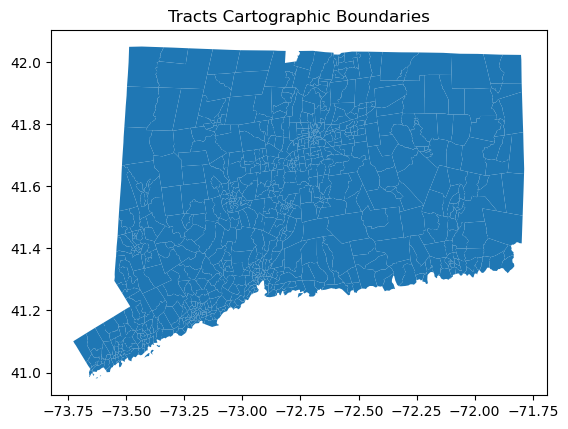

In [45]:
import pygris
from pygris import tracts
from matplotlib import pyplot as plt
import pandas as pd
import folium
import numpy as np
import geopandas as gp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import libpysal as lp
from scipy.stats import linregress
import rasterio
from rasterstats import zonal_stats


# Download geometry
ct_tracts = tracts(state = "CT", cb = True, cache = True, year = 2016)

# Display geometry
fig, ax = plt.subplots()
ct_tracts.plot(ax = ax)
plt.title("Tracts Cartographic Boundaries");

# Import tracts population data
pop = pd.read_csv("../data/population.csv")

# Convert data type so join key matches
ct_tracts["Geo_TRACT"] = ct_tracts["TRACTCE"].astype(int)

# Join attributes to geometry
tracts = ct_tracts.merge(pop, how = "inner", on='Geo_TRACT')

# Project tracts
tracts = tracts.to_crs("EPSG:3857")

# Calculate area in KM
tracts["Area"] = tracts.area/1000**2

# Calculate population density
tracts["PopDensity"] = tracts["SE_A00001_001"]/tracts["Area"]



In [46]:
# #import raster
# raster_path = 'ct_2016_ccap_hires_landcover_20200915.tif'
# landcover = rasterio.open(raster_path)
# arr = landcover.read(1)
# affine = landcover.transform

# zone = tracts.to_crs(landcover.crs)

In [47]:
# df_new = zonal_stats(zone, arr, affine=affine, categorical = True)

In [48]:
# df_categorical = pd.DataFrame(df_new)

# df_categorical['max_type'] = df_categorical.idxmax(axis=1)
# combined_df = pd.concat([tracts, df_categorical], axis=1)
# combined_df['max_type'] = combined_df['max_type'].astype(str)

# # save zonal stat to combined_data.csv
# combined_df.to_csv('combined_data.csv', index=False)

In [49]:
data = pd.read_csv("../data/combined_data.csv")
data[pd.isnull(data.iloc[:,68:-1])] = 0

X = data.iloc[:,68:-2]
y = data["PopDensity"]


In [50]:
gdf = gp.read_file('../data/tl_2016_09_tract.shp')

In [51]:
data
# 'GEOID' to str
gdf['TRACTCE'] = gdf['TRACTCE'].astype(int)
data['TRACTCE'] = data['TRACTCE'].astype(int)

In [52]:
# merge csv with shapfile using TRACTCE
merged_gdf = gdf.merge(data, on='TRACTCE', how='left')


# Spatial Autoregressive Model

In previous section, we predicted the population denisty of tracts, considering each tract as independent from each other. However, in reality, the population densisty of each tract is dependent on its neighbors. For example, in urban regions, high density tracts are typically surrounded by high density tracts (the opposite holds true in rural area tracts). The first law of geography states that "everything is related to everything else, but near things are more related than distant things." Spatial autoregression model considers the features of the surrounding objects as part of the prediction. In this section, we are going to implement spatial autoregressive model on predicting the density data. 

In this spatial autoregression model, we adopt queen criterion to construct spatial continuity weight matrix. The queen criterion defines neighbors as spatial units sharing a common edge or a common vertex. This means that in our model, we will add the features and characteristics of the neighboring tracts as part of the prediction variables. Below is an illustration of the queen continuity weight matrix. [Picture]("https://www.researchgate.net/figure/Diagram-of-the-queen-based-contiguity-weights-matrix_fig5_348782676"). 

To find the weight matrix, we need to introduce geometry to our dataset. Here, I am merging the csv file to a shapefile and convert the merged data to a GeoDataFrame format. Later, I calculate the queen spatial continuity matrix using the `libpysal` pacakge. Using the spatial weight continuity matrix, we can then calculate the spatial lag data of population density, which is the mean population density of the neighboring tracts. 

In [53]:
# make merged_gdf into geo dataframe
merged_gdf = gp.GeoDataFrame(merged_gdf)

# drop out all rows that have no population density
merged_gdf = merged_gdf.dropna(subset=['PopDensity'], axis=0)
# clean tracts that have truncated data on population density
merged_gdf = merged_gdf[merged_gdf['PopDensity'] != 0]
merged_gdf = merged_gdf[merged_gdf['TRACTCE'] != 194202]

# define the geometry_x column to be the geometry feature 
merged_gdf.set_geometry("geometry_x", inplace=True)

# calculate Queen's neighbor weights for each tracts
w = lp.weights.Queen.from_dataframe(merged_gdf)
w.transform = 'R'

/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == "polygon":
/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "linestring":


In [54]:
# compute spatial lag of population density
merged_gdf['spatial_lag_PopDens'] = lp.weights.lag_spatial(w, merged_gdf['PopDensity'])

# calculate the mean pop density of each tract's neighbors
#merged_gdf['avg_neighbor_density'] = merged_gdf.groupby('TRACTCE')['spatial_lag'].transform('mean')
merged_gdf['PopDensity'] = merged_gdf['PopDensity'].astype(float)

# download merged_gdf to csv file
merged_gdf.to_csv('../data/merged_gdf.csv', index=False)

Next, we want to perform a spatial autocorrelation evaluation using Global Moran's I index. This evaluation assesses the spatial distribution characteristic of the entire region. We plot the scatter plot between the population denisty and mean population denisty of tract's neighbors. The Global Moran's I index, if we do not delve into its mathematical details, is the slope of the best fit line between these two numbers. In our case, we calculated the Moran's I index to be 0.6. Together with the distribution of the scatter plot, we believe that population density of the neighboring tracts are dependent. We also want to inspect the spatial association at a local scale. Here we use Local Indicators of Spatial Association (LISA), which categorize each tract of based on its own population density and the population density of its surrounding tracts. LISA has four categories: High-High, High-Low, Low-High, Low-Low. High/low before the dash means whether the tract has a populuation density that is higher/lower than the mean overall population density. High/low after the dash means whether the tract's neighbors population denisty is above/below the average population density. After categorization, we map the tracts to inspect the distribution of the tracts' categories. We find that High-High tracts are usually in urban areas, Low-High tracts are usually suburbs, High-Low tracts are typically towns in the rural area, and Low-Low are rural tracts. Therefore, we believe that by taking into account the characteristics of the target tract's neighboring tract, we are able to predict population density better than ordinary least square regression. 

In [55]:
from sklearn.linear_model import LinearRegression

merged_csv_moran = pd.read_csv("../data/merged_gdf.csv", usecols=['PopDensity', 'spatial_lag_PopDens', "Geo_NAME"]).dropna()

# Extract x and y columns from the DataFrame
x = merged_csv_moran['PopDensity'].values.reshape(-1, 1)  # Reshape to make it a 2D array for scikit-learn
y = merged_csv_moran['spatial_lag_PopDens'].values

# Calculate the average for 'spatial_lag_PopDens' and 'PopDensity'
p = merged_csv_moran['spatial_lag_PopDens'].mean()
q = merged_csv_moran['PopDensity'].mean()

# Categorize the rows based on conditions
merged_csv_moran['category'] = 0  # Initialize category column
merged_csv_moran.loc[(merged_csv_moran['spatial_lag_PopDens'] >= p) & (merged_csv_moran['PopDensity'] >= q), 'category'] = 'High-High'
merged_csv_moran.loc[(merged_csv_moran['spatial_lag_PopDens'] >= p) & (merged_csv_moran['PopDensity'] < q), 'category'] = 'Low-High'
merged_csv_moran.loc[(merged_csv_moran['spatial_lag_PopDens'] < p) & (merged_csv_moran['PopDensity'] >= q), 'category'] = 'High-Low'
merged_csv_moran.loc[(merged_csv_moran['spatial_lag_PopDens'] < p) & (merged_csv_moran['PopDensity'] < q), 'category'] = 'Low-Low'



/var/folders/d5/f0qvkb_x4k1d4868jk4b1rzr0000gn/T/ipykernel_61416/2120357236.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'High-High' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_csv_moran.loc[(merged_csv_moran['spatial_lag_PopDens'] >= p) & (merged_csv_moran['PopDensity'] >= q), 'category'] = 'High-High'


/var/folders/d5/f0qvkb_x4k1d4868jk4b1rzr0000gn/T/ipykernel_61416/3818164290.py:34: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(handles=legend_patches + [scatter, plt.Line2D([0], [0], color='red', label=f'(y = {slope:.2f}x + {intercept:.2f})')])


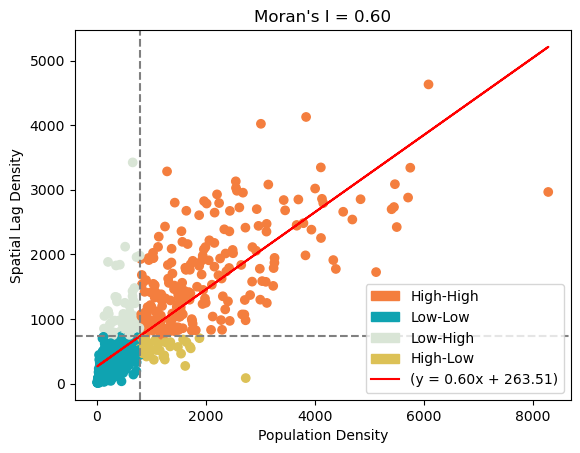

In [56]:
from matplotlib.patches import Patch
# Calculate the average for 'spatial_lag_PopDens' and 'PopDensity'
p = merged_csv_moran['spatial_lag_PopDens'].mean()
q = merged_csv_moran['PopDensity'].mean()

# Define custom colors for categories
colors = {'High-High': '#F47E3E', 'Low-Low': '#0FA3B1', 'Low-High': '#D9E5D6', 'High-Low': '#DCC156'}

# Create a scatter plot of x vs y
scatter = plt.scatter(x, y, color=merged_csv_moran['category'].map(colors))

# Fit a linear regression model
model = LinearRegression()
model.fit(x, y)

# Get the slope and intercept of the fitted line
slope = model.coef_[0]
intercept = model.intercept_

# Plot the fitted line
plt.plot(x, model.predict(x), color='red', label=f'Linear Regression (y = {slope:.2f}x + {intercept:.2f})')

# Add labels and title
plt.xlabel('Population Density')
plt.ylabel('Spatial Lag Density')
plt.title("Moran's I = 0.60")

# Create legend entries manually
legend_patches = [
    Patch(color=color, label=label) for label, color in colors.items()
]

# Add the legend with custom entries and regression equation
plt.legend(handles=legend_patches + [scatter, plt.Line2D([0], [0], color='red', label=f'(y = {slope:.2f}x + {intercept:.2f})')])

# Draw horizontal and vertical dashed line at y = p
plt.axhline(y=p, color='gray', linestyle='--')
plt.axvline(x=q, color='gray', linestyle='--')

# Show plot
plt.show()

/var/folders/d5/f0qvkb_x4k1d4868jk4b1rzr0000gn/T/ipykernel_61416/2219317344.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'High-High' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_gdf.loc[(merged_gdf['spatial_lag_PopDens'] >= p) & (merged_gdf['PopDensity'] >= q), 'category'] = 'High-High'
/var/folders/d5/f0qvkb_x4k1d4868jk4b1rzr0000gn/T/ipykernel_61416/2219317344.py:17: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged_gdf.plot(column='category', ax=ax, color=merged_gdf['category'].map(colors), legend=True)


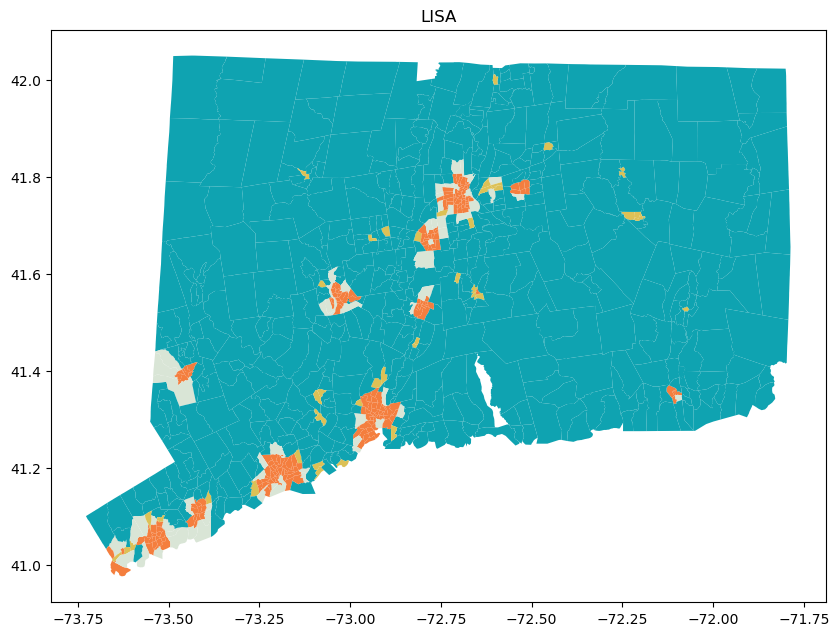

In [57]:
# Calculate the average for 'spatial_lag_PopDens' and 'PopDensity'
p = merged_gdf['spatial_lag_PopDens'].mean()
q = merged_gdf['PopDensity'].mean()

# Categorize the rows based on conditions
merged_gdf['category'] = 0  # Initialize category column
merged_gdf.loc[(merged_gdf['spatial_lag_PopDens'] >= p) & (merged_gdf['PopDensity'] >= q), 'category'] = 'High-High'
merged_gdf.loc[(merged_gdf['spatial_lag_PopDens'] >= p) & (merged_gdf['PopDensity'] < q), 'category'] = 'Low-High'
merged_gdf.loc[(merged_gdf['spatial_lag_PopDens'] < p) & (merged_gdf['PopDensity'] >= q), 'category'] = 'High-Low'
merged_gdf.loc[(merged_gdf['spatial_lag_PopDens'] < p) & (merged_gdf['PopDensity'] < q), 'category'] = 'Low-Low'

# Define custom colors for categories
colors = {'High-High': '#F47E3E', 'Low-Low': '#0FA3B1', 'Low-High': '#D9E5D6', 'High-Low': '#DCC156'}

# Plot the map using custom colors
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(column='category', ax=ax, color=merged_gdf['category'].map(colors), legend=True)
plt.title('LISA')
plt.show()

In [ ]:
import libpysal
from libpysal import weights
from libpysal.weights import Queen

Instead of using all possible land cover types, we are going to use land cover types that are more common among all tracts in CT for density prediction. The land cover types we selected are the same as the ones in linear regression section. 

In [61]:
# all landcover types
all_landcover = ['2', '5', '8', '11', '12', '13', '14', '15', '17', '18', '19', '20', '21', '22', '7', '6', '0', '23']
all_landcover_pct = ['2pct', '5pct', '8pct', '11pct', '12pct', '13pct', '14pct', '15pct', '17pct', '18pct', '19pct', '20pct', '21pct', '22pct', '7pct', '6pct', '0pct', '23pct']

# selected landcover types
landcover_types = ['2', '5', '11', '12', '8', '13', '14', '15', '20', '21'] #, '22', '7', '8', '13', '14', '15', '20', '21'
landcover_pct = ['2pct', '5pct', '11pct', '12pct', '8pct', '13pct', '14pct', '15pct', '20pct', '21pct'] # , '22pct', '7pct', '8pct', '13pct', '14pct', '15pct', '20pct', '21pct'

merged_gdf['sum'] = merged_gdf[all_landcover].sum(axis=1)
#merged_gdf['sum'] = merged_gdf.apply(lambda row: row['2'] + row['5'], axis=1)
merged_gdf[all_landcover_pct] = merged_gdf[all_landcover].div(merged_gdf['sum'], axis=0).multiply(100).astype(float)

# download merged_gdf to csv file
merged_gdf.to_csv('merged_gdf_1111.csv', index=False)

In [62]:
merged_gdf[landcover_pct]

,2pct,5pct,11pct,12pct,8pct,13pct,14pct,15pct,20pct,21pct
0,5.509411,10.073634,70.149387,0.331384,2.426544,3.844710,0.068588,0.164714,0.417731,3.502923
1,40.143618,22.572331,14.879245,0.518366,0.282125,0.000000,0.000000,0.000000,0.691257,1.196337
2,7.129000,8.445676,73.558606,0.461241,2.760445,1.751201,0.015770,0.090196,0.221618,4.829785
3,7.855967,10.986274,62.391491,1.010302,3.775882,2.784153,0.296052,1.574821,0.708541,1.256457
4,11.742686,17.471010,36.488909,0.198040,4.718261,17.349571,0.049821,1.631335,0.089429,0.000000
...,...,...,...,...,...,...,...,...,...,...
836,26.806007,16.308251,39.523614,1.371744,0.866811,0.280456,0.003717,0.137962,1.558064,11.313918
837,3.392611,6.525060,59.665926,1.267400,5.105651,3.662684,0.468378,1.985569,0.432288,2.508637
838,11.548541,12.529011,60.177059,1.680287,2.200802,4.718876,0.141902,0.368327,0.625119,4.657739
839,11.565276,9.029357,35.562615,4.313724,1.169918,0.656492,0.070241,0.388492,2.528447,25.737052


### Spatially lagged endogenous/exogenous regressors

There are two types of spatially lagged regression models. The first one is **spatially lagged endogenous regression model**. The endogenous model includes the spatial lagged value of the target variable as one of the explanatory variables for regression. In our case, the population density of a tract's neighbor is part of the variables we use to predict the population density of the tract.

The second type of spatially lagged regression model is **spatially lagged exogenous regression model**. Instead of taking into account the population density, our target variable, of the neighboring tracts, the exogenous model considers the explanatory variables of the tract's surroundings. In our case, the spatially lagged exogenous model adds neighbors' land type information to the model. We will calculate the spatial lagged value of each land cover type for all tracts and include them as part of the predictor variables.

We first fit both models to the entirety of CT and map their residuals on each tract. 

endogenous model

In [63]:
# endogenous model: consider spatial lag population denisty
predictor = landcover_pct + ['spatial_lag_PopDens']

# get explanatory variables and target variable
X_merged_gdf = merged_gdf[predictor].values
y_merged_gdf = merged_gdf['PopDensity'].values.reshape(-1, 1)

# perform regression. 
model = LinearRegression()
model.fit(X_merged_gdf, y_merged_gdf)

# predict values
y_pred = model.predict(X_merged_gdf)
residuals = y_merged_gdf - y_pred

# add residual to table
merged_gdf['residuals'] = residuals

merged_gdf.drop(columns=['spatial_lag_PopDens'], inplace=True)

exogenous model. 
### (I commented out the residual percentage plot but feel free to uncomment it and add it somewhere to support the narrative.) 

In [69]:
# exogenous model: consider
exo_predictor = landcover_pct + ['lag_2pct', 'lag_5pct', 'lag_11pct', 'lag_12pct', 'lag_8pct', 'lag_13pct', 'lag_14pct', 'lag_15pct', 'lag_20pct', 'lag_21pct'] 

for i in range(len(landcover_pct)):
        merged_gdf['lag_' + landcover_pct[i]] = lp.weights.lag_spatial(w, merged_gdf[landcover_pct[i]])

X_merged_gdf_exo = merged_gdf[exo_predictor].values
y_merged_gdf_exo = merged_gdf['PopDensity'].values.reshape(-1, 1)

model_exo = LinearRegression()
model_exo.fit(X_merged_gdf_exo, y_merged_gdf_exo)

y_pred_exo = model_exo.predict(X_merged_gdf_exo)
residuals_exo = y_merged_gdf_exo - y_pred_exo


# ###
# residual_percent = (residuals_exo / y_merged_gdf_exo) * 100 
# merged_gdf['residuals_exo_percent'] = residual_percent
# ###

merged_gdf['residuals_exo'] = residuals_exo

# fig, ax = plt.subplots(figsize=(10, 10))
# merged_gdf.plot(column='residuals_exo_percent', cmap='twilight_shifted', legend=True, ax=ax, vmax = 1000)

# #merged_gdf.plot(column='residuals_percent', cmap='twilight_shifted', legend=True, ax=ax, vmin=-600)
# #zoomed in area with lots of mis
# #ax.set_ylim([41.6, 41.8])
# #ax.set_xlim([-72.9, -72.5])

# plt.title('Spatial Distribution of Residuals')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

Compare the residual map of the two models

In [70]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy as np

# Define the colors for the custom colormap
colors = [(0, 'brown'), (0.5, 'white'), (1, 'green')]  # Position 0 is brown, position 0.5 is white, position 1 is green

# Create the colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Determine the range of residuals to be used for normalization
residuals_max = max(abs(merged_gdf['residuals_exo'].max()), abs(merged_gdf['residuals'].max()))
vmax = residuals_max * 0.75  # Adjust the factor as needed

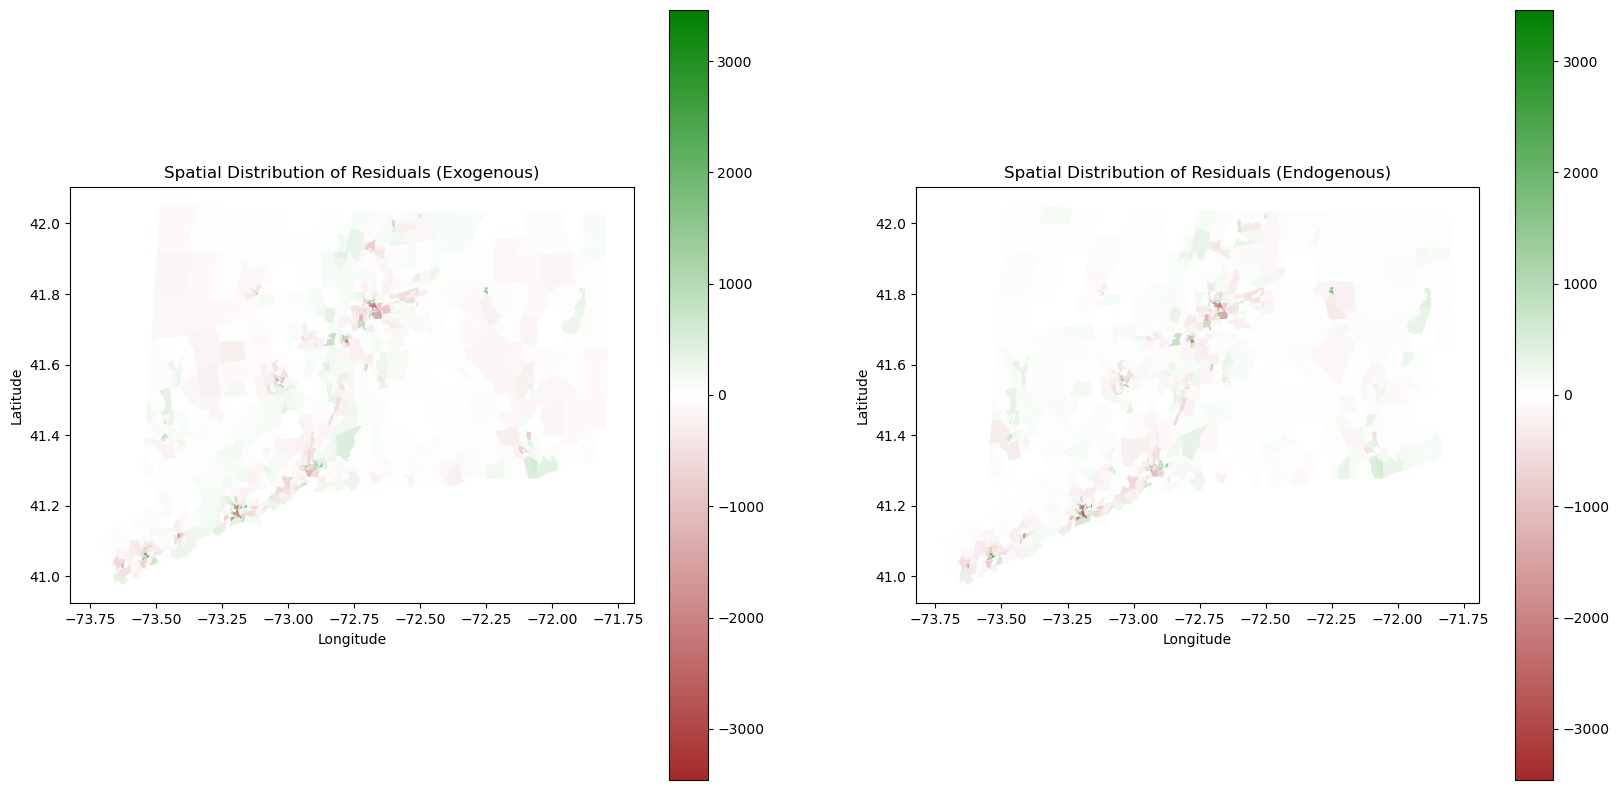

In [71]:
# Create a normalization object
norm = Normalize(vmin=-vmax, vmax=vmax)

# First graph
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Create a figure with 1 row and 2 columns

# Graph 1 - Exogenous variables
merged_gdf.plot(column='residuals_exo', cmap=cmap, legend=True, ax=axes[0], vmax=vmax, norm=norm)
axes[0].set_title('Spatial Distribution of Residuals (Exogenous)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Graph 2 - Spatial lag of PopDensity
merged_gdf.plot(column='residuals', cmap=cmap, legend=True, ax=axes[1], vmax=vmax, norm=norm)
axes[1].set_title('Spatial Distribution of Residuals (Endogenous)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.show()

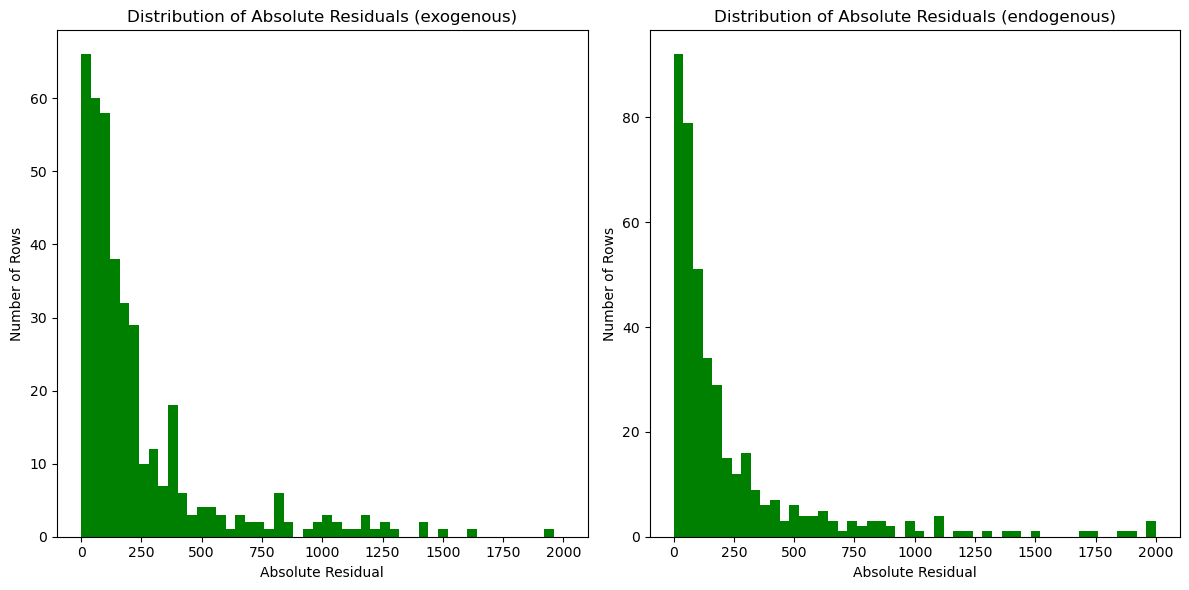

In [92]:
num_bins = 50
hist_range = (0, 2000)

# Create subplots with two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first histogram
axs[0].hist(merged_gdf['residuals_exo'], bins=num_bins, range=hist_range, color='green')
axs[0].set_xlabel('Absolute Residual')
axs[0].set_ylabel('Number of Rows')
axs[0].set_title('Distribution of Absolute Residuals (exogenous)')

# Plot the second histogram
axs[1].hist(merged_gdf['residuals'], bins=num_bins, range=hist_range, color='green')
axs[1].set_xlabel('Absolute Residual')
axs[1].set_ylabel('Number of Rows')
axs[1].set_title('Distribution of Absolute Residuals (endogenous)')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

## ^^COMMENT ABOUT THE MAP^^
The exogenous spatial lag residual map is on the left and the endogenous spatial lag residual map is on the right. Qualitatively assessing the these two maps, we see both models tend to underestimate the population density in urban areas. It is reasonable as land cover data is only two dimensional and does not account for the vertical height of the buildings. Both models tend to have a better performance at predicting density in less populated areas (Low-Low tracts). The residual historgrams of the two models are similar. 

A zoom-in comparison map for Hartford

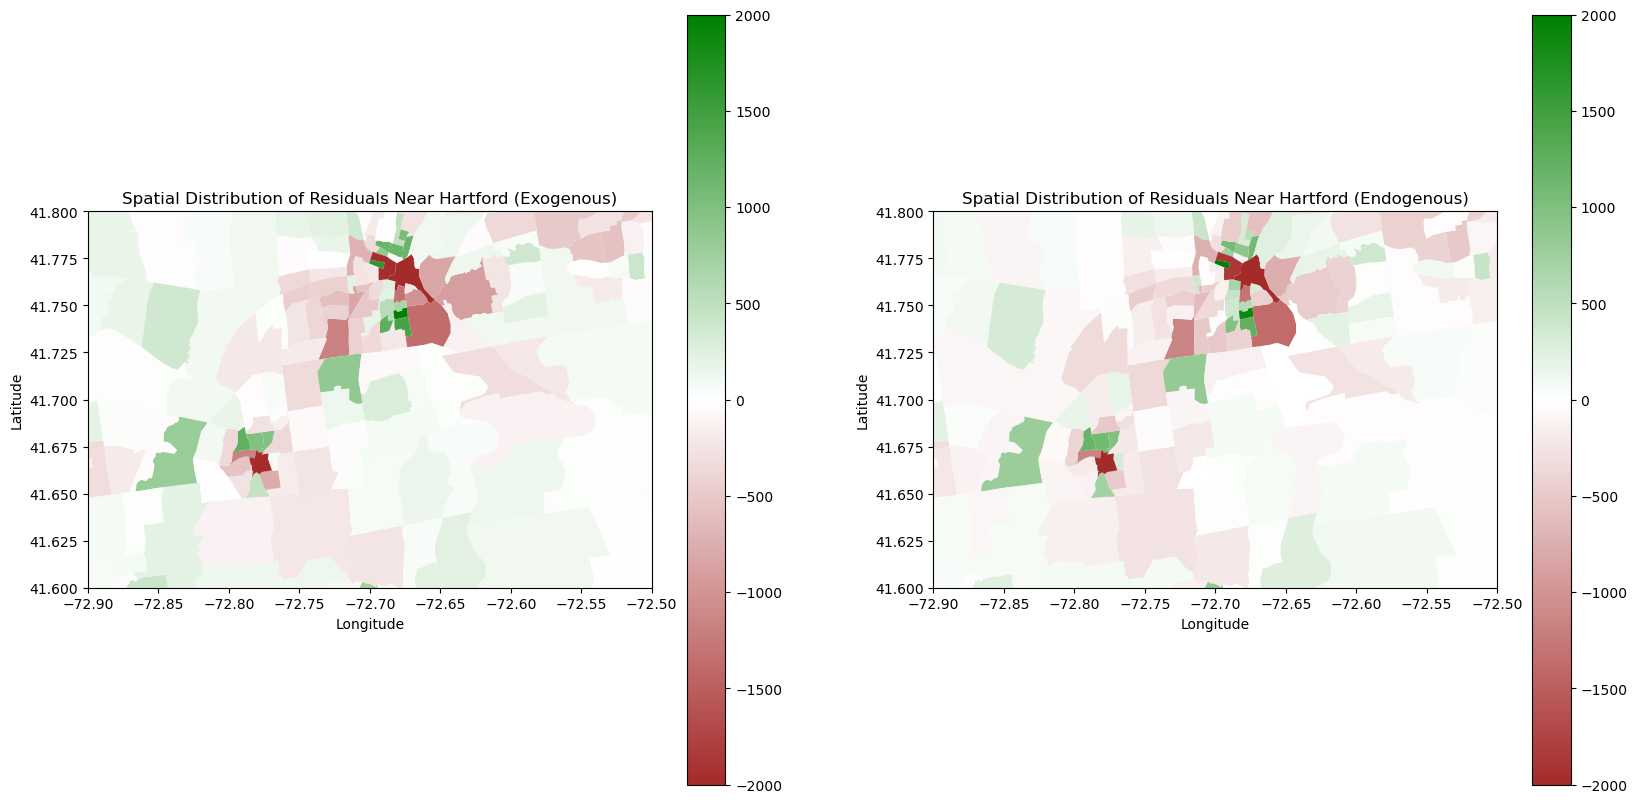

In [74]:
# Create a normalization object
norm = Normalize(vmin=-2000, vmax=2000)

# First graph
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Create a figure with 1 row and 2 columns

# Graph 2 - Exogenous variables
merged_gdf.plot(column='residuals_exo', cmap=cmap, legend=True, ax=axes[0], vmax=vmax, norm=norm)
axes[0].set_title('Spatial Distribution of Residuals Near Hartford (Exogenous)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Graph 1 - Spatial lag of PopDensity
merged_gdf.plot(column='residuals', cmap=cmap, legend=True, ax=axes[1], vmax=vmax, norm=norm)
axes[1].set_title('Spatial Distribution of Residuals Near Hartford (Endogenous)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

axes[0].set_ylim([41.6, 41.8])
axes[0].set_xlim([-72.9, -72.5])
axes[1].set_ylim([41.6, 41.8])
axes[1].set_xlim([-72.9, -72.5])

plt.show()

## ^^COMMENT ABOUT THE MAP^^

### Training and Testing Cross Validation

For training and testing, we need to separate the data into two. Due to the spatial dependence of tracts, we cannot randomly select tracts from the dataset and assign them to either training or testing data because neighboring tracts will not be in the same dataset. Therefore, to minimize the rupture of spatial relations, we decide to separate training and testing data by neighboring **counties** to ensure that all tracts in training and testiing data are countinuous. Later, we perform for loops on each set of training and testing data and calculate their mean RMSE for each training and testing set for both endogenous and exogenous model. 

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
merged_csv = pd.read_csv("../data/merged_gdf.csv")

# extract the county name from the the Geo_NAME column. 
merged_gdf['County'] = merged_gdf['Geo_NAME'].str.split(',').str[1].str.strip().str.replace(' ', '')
merged_gdf = merged_gdf.dropna(subset=['County'])

In [29]:
# Spatially lagged endogenous regressors
odd_counties = ['NewLondonCounty', 'NewHavenCounty', 'LitchfieldCounty', 'TollandCounty']
even_counties = ['MiddlesexCounty', 'FairfieldCounty','HartfordCounty', 'WindhamCounty']

rmse = []

for i in range(4):
    # spliting training and testing counties
    train_1 = merged_gdf[(merged_gdf['County'] != odd_counties[i]) & (merged_gdf['County'] != even_counties[i])]
    test_1 = merged_gdf[(merged_gdf['County'] == odd_counties[i]) | (merged_gdf['County'] == even_counties[i])]

    # queen weight matrix for each train and test
    train_1_w = Queen.from_dataframe(train_1)
    test_1_w = Queen.from_dataframe(test_1)
    # regularize the weights
    train_1_w.transform = 'R'
    test_1_w.transform = 'R'
    # calculate the spatial lag pop density
    train_1['spatial_lag_PopDens'] = lp.weights.lag_spatial(train_1_w, train_1['PopDensity'])
    test_1['spatial_lag_PopDens'] = lp.weights.lag_spatial(test_1_w, test_1['PopDensity'])
    
    y_train = np.array(train_1['PopDensity']).reshape((-1,1))
    x_train = np.array(train_1[predictor])

    y_test = np.array(test_1['PopDensity'])
    x_test = np.array(test_1[predictor])

    # IT WOULD BE GREAT IF WE CAN USE OUR OWN LINEAR REGRESSION.PY!
    # Fit linear regression model using scikit-learn 
    model = LinearRegression()
    model.fit(x_train, y_train)

    # Predict on test data
    y_pred_test = model.predict(x_test)

    # Calculate RMSE
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    rmse.append(test_rmse)


/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == "polygon":
/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "linestring":
/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [38]:
np.mean(rmse)

382.2755370253545

The average root mean square error of the spatially lagged endogenous regression model is 382.28. The endogenous model is more advantageous when we have a relatively higher coverage of census data and we need to predict the population density of small region surrounded by regions with good census. 

Next, we do training and testing cross validation for the exogenous spatial lagged model. 

In [ ]:
# Spatially lagged exogenous regressors

rmse_exo = []

for i in range(4):

    train_1 = merged_gdf[(merged_gdf['County'] != odd_counties[i]) & (merged_gdf['County'] != even_counties[i])]
    test_1 = merged_gdf[(merged_gdf['County'] == odd_counties[i]) | (merged_gdf['County'] == even_counties[i])]

    train_1_w = Queen.from_dataframe(train_1)
    test_1_w = Queen.from_dataframe(test_1)

    train_1_w.transform = 'R'
    test_1_w.transform = 'R'

    for j in range(len(landcover_pct)):
        train_1['lag_' + landcover_pct[j]] = lp.weights.lag_spatial(train_1_w, train_1[landcover_pct[j]])
        test_1['lag_' + landcover_pct[j]] = lp.weights.lag_spatial(test_1_w, test_1[landcover_pct[j]])
    

    y_train = np.array(train_1['PopDensity']).reshape((-1,1))
    x_train = np.array(train_1[exo_predictor])

    y_test = np.array(test_1['PopDensity'])
    x_test = np.array(test_1[exo_predictor])

    # IT WOULD BE GREAT IF WE CAN USE OUR OWN LINEAR REGRESSION.PY!
    # Fit linear regression model using scikit-learn 
    model = LinearRegression()
    model.fit(x_train, y_train)

    # Predict on test data
    y_pred_test = model.predict(x_test)

    # Calculate RMSE
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    rmse_exo.append(test_rmse)

In [39]:
np.mean(rmse_exo)

391.6656169255299

The average RMSE of the spatially lagged endogenous regression model cross validation is 391.67, which is slightly larger than the RMSE of the endogenous model. The exogenous model is more applicable to scenarios when we have good satellite data but sparse census data. 

. 

.

.

## XXX Below this line records my attempt to harness ML_Lag but I was not successful XXX
-------------------------------------------------------------------

In [167]:
model1 = ML_Lag(y=y_train, x=x_train, w=train_1_w, name_y='PopDensity', name_x=landcover_pct, name_w='SpatialWeightsMatrix')
# the coefficients of the model
model1.betas

/home/manny/anaconda3/envs/ml-0451/lib/python3.11/site-packages/spreg/diagnostics.py:354: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
/home/manny/anaconda3/envs/ml-0451/lib/python3.11/site-packages/spreg/diagnostics.py:170: RuntimeWarning: invalid value encountered in sqrt
  ) / np.sqrt(variance)


ValueError: Length mismatch: Expected axis has 13 elements, new values have 12 elements

In [124]:
# output for the model
print(model1.summary)

NameError: name 'model1' is not defined

In [42]:
# SEE OUTPUT FOR GM_Lag
# Build full table of regression coefficients
# pd.DataFrame(
#     {
#         # Pull out regression coefficients and
#         # flatten as they are returned as Nx1 array
#         "Coeff.": model.betas.flatten(),
#         # Pull out and flatten standard errors
#         "Std. Error": model.std_err.flatten(),
#         # Pull out P-values from t-stat object
#         "P-Value": [i[1] for i in model.z_stat],
#     },
#     # Round to four decimals
# ).round(4)

/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


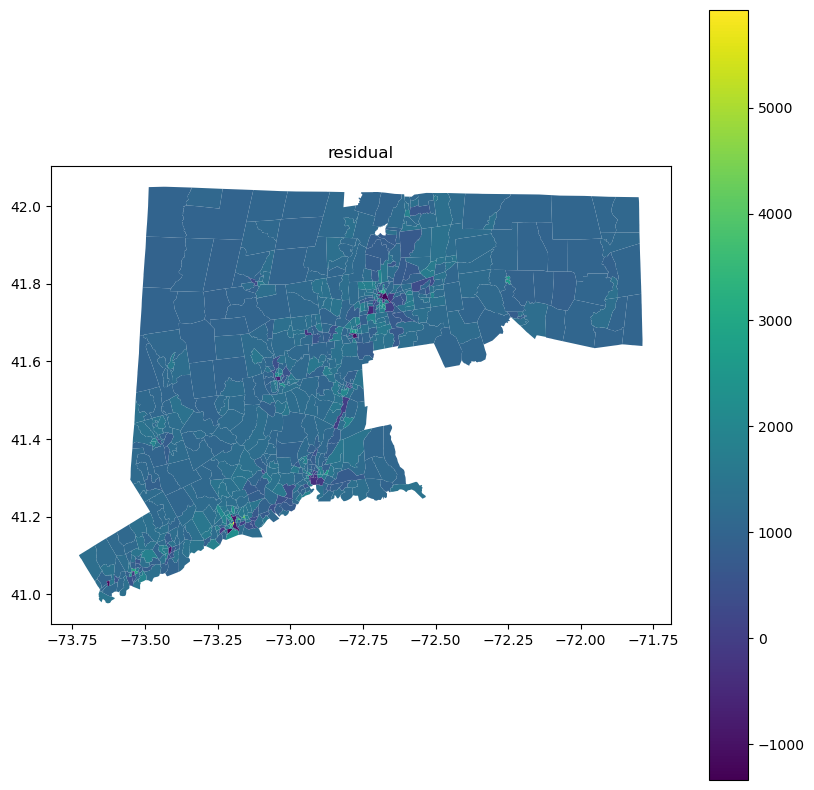

In [151]:
train_1['lag_pred'] = model.predy_e
train_1['y_hat_lag_pred'] = train_1['PopDensity'] - train_1['lag_pred']

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
train_1.plot(column='y_hat_lag_pred', cmap='viridis', legend=True, ax=ax)
plt.title('residual')
plt.show()

In [144]:
model_error = ML_Error(y=y_train, x=x_train, w=train_1_w, name_y='PopDensity', name_x=landcover_pct, name_w='SpatialWeightsMatrix')

/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/spreg/ml_error.py:528: RuntimeWarning: invalid value encountered in log
  nlsig2 = (n / 2.0) * np.log(sig2)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/spreg/diagnostics.py:354: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/spreg/diagnostics.py:170: RuntimeWarning: invalid value encountered in sqrt
  ) / np.sqrt(variance)


In [145]:
print(model_error.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :SpatialWeightsMatrix
Dependent Variable  :  PopDensity                Number of Observations:         726
Mean dependent var  :    867.2255                Number of Variables   :          11
S.D. dependent var  :   1071.7093                Degrees of Freedom    :         715
Pseudo R-squared    :      0.7355
Log likelihood      :  -5159.2459
Sigma-square ML     : 392288.2249                Akaike info criterion :   10340.492
S.E of regression   :    626.3292                Schwarz criterion     :   10390.955

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      1536.0

In [119]:
# estimate of spatial autoregressive coefficient
"{0:.6f}".format(model.rho) 

'-0.024751'

In [127]:
# Sum of squared residuals
"{0:.4f}".format(model.utu)

'1336430201.3650'

/var/folders/d5/f0qvkb_x4k1d4868jk4b1rzr0000gn/T/ipykernel_61603/3862628888.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf.centroid.plot(ax=ax, c='black')


<Axes: >

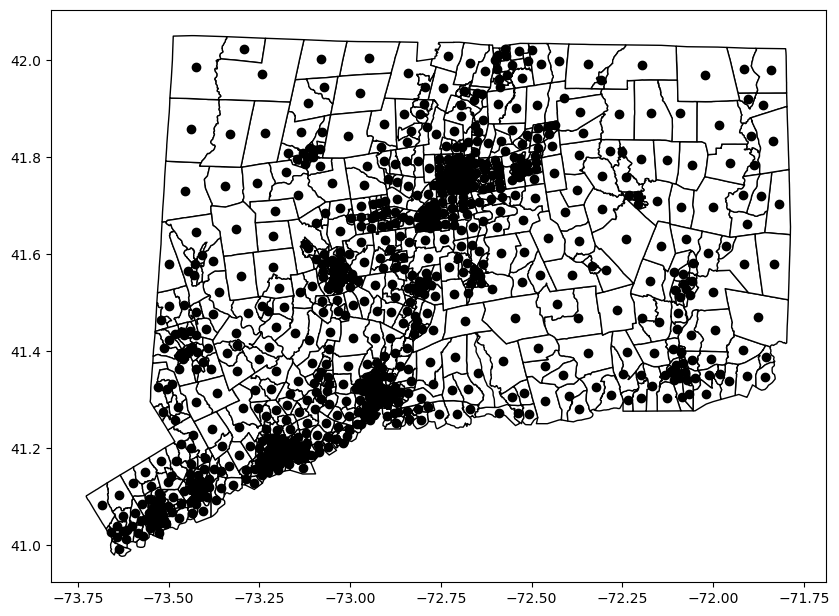

In [448]:
fig, ax = plt.subplots(figsize=(10,10))
merged_gdf.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
merged_gdf.centroid.plot(ax=ax, c='black')

In [452]:
centroids = merged_gdf.geometry.centroid

# Extract longitude and latitude
longitude = centroids.x
latitude = centroids.y

g_coords = list(zip(longitude,latitude))


/var/folders/d5/f0qvkb_x4k1d4868jk4b1rzr0000gn/T/ipykernel_61603/777703877.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = merged_gdf.geometry.centroid
